In [1]:
from cdapython import unique_terms, Q
import requests
import pprint
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import math

In [2]:
def goPie(project, catdata):
    catlist = []
    countlist = []
    for category, count in catdata.items():
        catlist.append(category)
        countlist.append(count)
    fig = go.Pie(labels=catlist, values=countlist, title_text=project, textinfo='value')
    return fig

        

In [3]:
def pexPie(project, catdata):
    #Expects an list of {datacategory:count}
    catlist = []
    countlist = []
    for category,count in catdata.items():
        catlist.append(category)
        countlist.append(count)
    fig = px.pie(values=countlist, names=catlist, title = project)
    return fig

In [4]:
def plotlySubplots(jsondata, cols, rows, height, title):
    #Need to have a specs row for each row in the subplot and each row has to define each column
    collist = []
    x = 1
    while x <= cols:
        collist.append({'type': 'pie'})
        x += 1
    speclist =[]
    x = 1
    while x<= rows:
        speclist.append(collist)
        x +=1

    subfig = make_subplots(rows=rows, cols=cols, specs=speclist)
    tempcol = 1
    temprow = 1
    for project,data in jsondata.items():
        if data:
            fig = goPie(project, data)
            subfig.add_trace(fig,row = temprow, col = tempcol)  
            if tempcol == cols:
                tempcol = 1
                temprow = temprow + 1
            else:
                tempcol = tempcol + 1
        subfig.update_layout(height= height, title_text=title)
    return subfig            

In [5]:
def getProjects(testmode):
    if testmode:
        #projectlist = ["TCGA-UCS", "TCGA-OV", "TCGA-GBM","TCGA-KICH", "TCGA-KIRC", "TCGA-BRCA"]
        projectlist = ["TCGA-BRCA"]
    else:
        projectlist = unique_terms("ResearchSubject.associated_project")
        #projectquery = """SELECT DISTINCT(_project) FROM gdc-bq-sample.cda_mvp.v3, UNNEST(ResearchSubject) AS _ResearchSubject, UNNEST(_ResearchSubject.Specimen) AS _Specimen, UNNEST(_Specimen.File) AS _File, UNNEST(_File.associated_project) as _project"""
        #resultsid = runNewAPIQuery(projectquery, None)
        #projresults = getResults(resultsid,0,100)
        #projectlist = []
        #for projresult in projresults['result']:
        #    projectlist.append(projresult['_project'])
    return projectlist

In [6]:
def runAPIQuery(querystring, limit):
    #Using a limit:
    if limit is not None:
        cdaURL = "https://cda.cda-dev.broadinstitute.org/api/v1/sql-query/v3?limit={}".format(str(limit))
    else:
        cdaURL = 'https://cda.cda-dev.broadinstitute.org/api/v1/sql-query/v3'
    headers = {'accept' : 'application/json', 'Content-Type' : 'text/plain'}

    request = requests.post(cdaURL, headers = headers, data = querystring)

    if request.status_code == 200:
        return request.json()
    else:
        raise Exception ("Query failed code {}. {}".format(request.status_code,query))


In [7]:
def runNewAPIQuery(querystring,limit):
    #Due to a change in the API, queries now return a query ID, not the result.
    if limit is not None:
        cdaURL = "https://cda.cda-dev.broadinstitute.org/api/v1/sql-query/v3?limit={}".format(str(limit))
    else:
        #cdaURL = 'https://cda.cda-dev.broadinstitute.org/api/v1/sql-query/v3'
        cdaURL = 'https://cda.cda-dev.broadinstitute.org/api/v1/sql-query'
    headers = {'accept' : 'application/json', 'Content-Type' : 'text/plain'}

    request = requests.post(cdaURL, headers = headers, data = querystring)

    if request.status_code == 200:
        result = request.json()
        query_id = result['query_id']
        return query_id
    else:
        raise Exception ("Query failed code {}. {}".format(request.status_code))

In [8]:
def runLibQuery(querystring):
    results = Q.sql(querystring)
    return results

In [9]:
def getResults(queryid, offset, limit):
    #curl -X GET "https://cda.cda-dev.broadinstitute.org/api/v1/query/bcff531e-0ada-4d43-9d81-ae9ab05efacb?offset=10&limit=100" -H "accept: application/json"
    resultURL = "https://cda.cda-dev.broadinstitute.org/api/v1/query/{}?offset={}&limit={}".format(queryid, str(offset), str(limit))
    #pprint.pprint(resultURL)
    headers = {'accept' : 'application/json'}
    
    request = requests.get(resultURL, headers = headers)
    
    if request.status_code == 200:
        #pprint.pprint(request.json())
        return request.json()
    else:
        raise Exception ("Query failed code {}. {}".format(request.status_code))
    

In [10]:
def samplePerDataCategory(project):
    querystring = """SELECT COUNT(DISTINCT _Specimen.id) AS spec_count, _FILE.data_category FROM gdc-bq-sample.cda_mvp.v3, 
        UNNEST(ResearchSubject) AS _ResearchSubject, UNNEST(_ResearchSubject.Specimen) AS _Specimen, UNNEST(_Specimen.File) 
        AS _File, UNNEST(_File.associated_project) as _project WHERE _project= '{}' GROUP BY _File.data_category""".format(project)
    return querystring

In [11]:
def parseSamplePerDataCategory(results):
    finaldata = {}
    #finaldata['next_url'] = str(results['next_url'])
    for result in results['result']:
        finaldata[result['data_category']] = result['spec_count']
    return finaldata

In [12]:
def parseLibSamplePerDataCategory(results):
    finaldata = {}
    for result in results:
        finaldata[result['data_category']] = result['spec_count']
        #pprint.pprint(result)
    return finaldata

<font color=blue> The section below uses the API directly</font>

In [26]:
#projectlist = getProjects(False)
projectlist = getProjects(True)
projectcount = len(projectlist)
countdata = {}
resultsets = {}
for project in projectlist:
    querystring = samplePerDataCategory(project)
    try:
        apiresults = runNewAPIQuery(querystring, None)
        resultsets[project] = apiresults
    except Exception as e:
        pprint.pprint(e)
pprint.pprint("Completed")

'Completed'


<font color=blue>This section functions the same as the previous, but uses the cdapython Q.sql function instead to run the query</font>

In [48]:
projectlist = getProjects(False)
projectcount = len(projectlist)
countdata = {}
for project in projectlist:
    querystring = samplePerDataCategory(project)
    libresults = runLibQuery(querystring)
    countdata[project] = parseLibSamplePerDataCategory(libresults)
pprint.pprint("Completed")


QueryID: 642c21ed-6cce-4094-9ab1-74816fdd9f75
Query: SELECT COUNT(DISTINCT _Specimen.id) AS spec_count, _FILE.data_category FROM gdc-bq-sample.cda_mvp.v3, 
        UNNEST(ResearchSubject) AS _ResearchSubject, UNNEST(_ResearchSubject.Specimen) AS _Specimen, UNNEST(_Specimen.File) 
        AS _File, UNNEST(_File.associated_project) as _project WHERE _project= 'GENIE-MSK' GROUP BY _File.data_category
Offset: 0
Count: 3
Total Row Count: 3
More pages: False


QueryID: 69184d01-dfac-425f-a1e7-863ec3d56655
Query: SELECT COUNT(DISTINCT _Specimen.id) AS spec_count, _FILE.data_category FROM gdc-bq-sample.cda_mvp.v3, 
        UNNEST(ResearchSubject) AS _ResearchSubject, UNNEST(_ResearchSubject.Specimen) AS _Specimen, UNNEST(_Specimen.File) 
        AS _File, UNNEST(_File.associated_project) as _project WHERE _project= 'GENIE-DFCI' GROUP BY _File.data_category
Offset: 0
Count: 2
Total Row Count: 2
More pages: False


QueryID: 1654d0a7-b40d-48b0-89ec-a4563344c497
Query: SELECT COUNT(DISTINCT _Spec

<font color=blue> The section below requires direct API results.  It queries for the resultsID and then parses that.  Will not work with results from Q</font>

In [27]:
for disease, resultid in resultsets.items():
    try:
        results = getResults(resultid,0,10)
        parsedresults = parseSamplePerDataCategory(results)
        #pprint.pprint(parsedresults)
        countdata[disease] = parsedresults
    except Exception as e:
        pprint.pprint(e)
pprint.pprint("Completed")
    

'Completed'


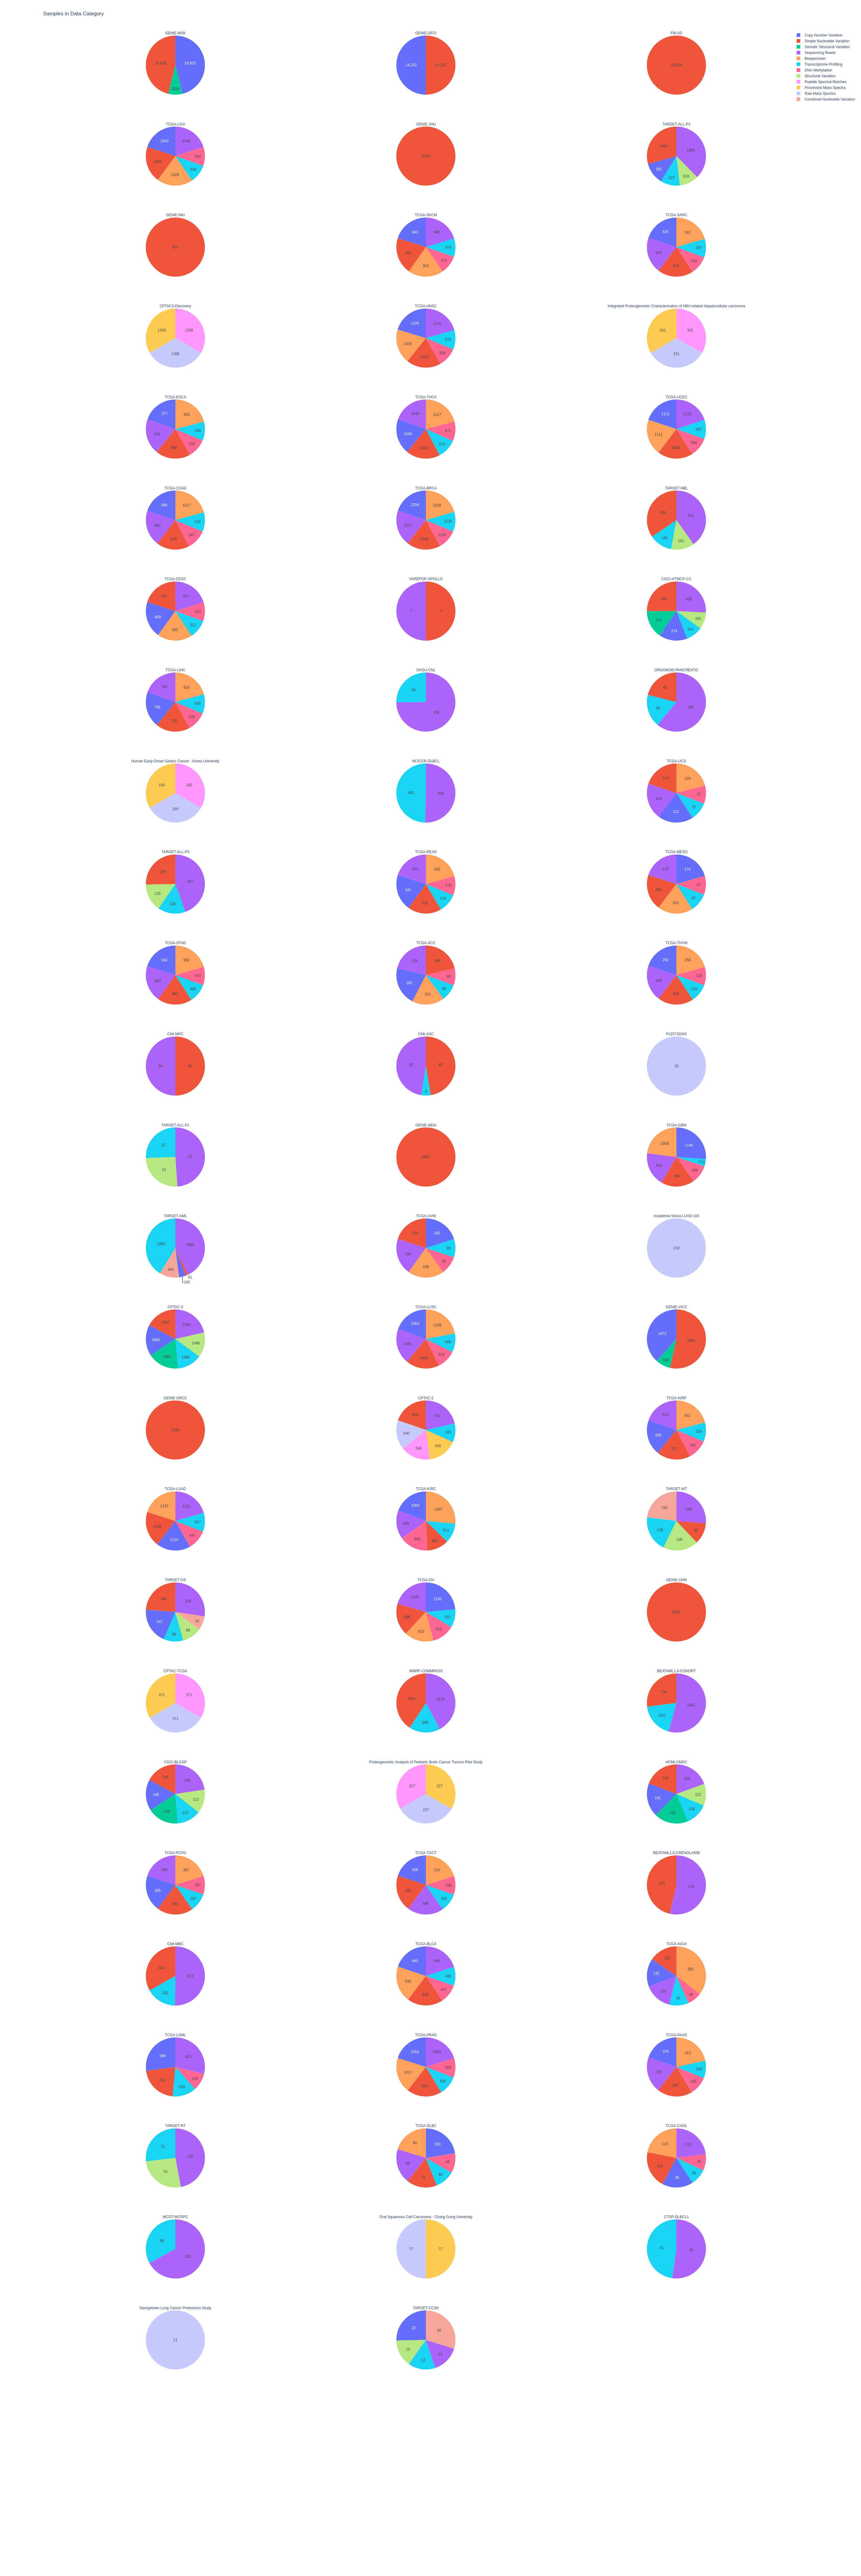

In [49]:
cols = 3
rows = math.ceil(projectcount/cols)
height =300*rows
title = 'Samples in Data Category'
plotlySubplots(countdata, cols, rows, height,title)